In [1]:
#code to mount folder called 'copied2' and extract faces from images.
#copied2 contains images obtained from the Kaggle dataset(class[imgs]>60))+ my images
import cv2
import os

# Define the source and destination folder paths
source_folder_path = '/content/drive/MyDrive/copied2'
destination_folder_path = '/content/extracted_faces'

# Ensure the destination folder exists
os.makedirs(destination_folder_path, exist_ok=True)

# Load the pre-trained Haar cascade classifiers
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
class_names=[]
# Function to extract faces and save them with the same name as the original image
def extract_and_save_faces(subfolder_name):
    subfolder_path = os.path.join(source_folder_path, subfolder_name)
    for filename in os.listdir(subfolder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(subfolder_path, filename)
            image = cv2.imread(image_path)
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5)

            for i, (x, y, w, h) in enumerate(faces):
                face = image[y:y+h, x:x+w]
                # Save the face with the same file name in a separate subfolder for each label
                face_subfolder_path = os.path.join(destination_folder_path, subfolder_name)
                os.makedirs(face_subfolder_path, exist_ok=True)
                face_filename = os.path.join(face_subfolder_path, filename)
                cv2.imwrite(face_filename, face)

# Iterate through each subfolder (label) and extract faces
for label in os.listdir(source_folder_path):
    if os.path.isdir(os.path.join(source_folder_path, label)):
        class_names.append(label)
        extract_and_save_faces(label)

print("Face extraction and saving process is complete.")
print(class_names)

Face extraction and saving process is complete.
['Tony_Blair', 'Donald_Rumsfeld', 'Suyash_Bhatt', 'Gerhard_Schroeder', 'George_W_Bush', 'Colin_Powell', 'Hugo_Chavez', 'Ariel_Sharon']


In [2]:
pip install scikit-learn


In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the dataset path
dataset_path = '/content/extracted_faces'

# Define paths for train, validation, and test sets in the current directory
train_path = 'train'
val_path = 'val'
test_path = 'test'

# Function to split data and move files.Split ratio training 70% , Validation =25%, test =5%
#Instead of test dataset , we use real time image for prediction in the end .
def split_data(source, train_dest, val_dest, test_dest, train_size=0.7, val_size=0.25, test_size=0.05):
    # Get all file names
    files = [file for file in os.listdir(source) if os.path.isfile(os.path.join(source, file))]

    # Split the data into train and temporary test set
    train_files, temp_test_files = train_test_split(files, train_size=train_size, random_state=42)

    # Adjust the ratio for splitting into validation and test sets
    remaining_size = 1 - train_size
    adjusted_val_size = val_size / remaining_size
    # Split the temporary test set into validation and test sets
    val_files, test_files = train_test_split(temp_test_files, train_size=adjusted_val_size, random_state=42)

    # Function to copy files
    def copy_files(files, destination):
        if not os.path.exists(destination):
            os.makedirs(destination)
        for file in files:
            shutil.copy(os.path.join(source, file), os.path.join(destination, file))

    # Copy files to respective directories
    copy_files(train_files, train_dest)
    copy_files(val_files, val_dest)
    copy_files(test_files, test_dest)

# Iterate over each label directory and split the files
for label_dir in os.listdir(dataset_path):
    label_dir_path = os.path.join(dataset_path, label_dir)
    if os.path.isdir(label_dir_path):
        split_data(label_dir_path,
                   os.path.join(train_path, label_dir),
                   os.path.join(val_path, label_dir),
                   os.path.join(test_path, label_dir))

print("Dataset splitting complete.")


Dataset splitting complete.


In [4]:
#augmentation is done later .This folder is not utilized therefore
# Import the os module to interact with the file system
import os
# Import necessary functions and classes from keras for image processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
# Import numpy for numerical operations
import numpy as np

# Define the directory paths for the original and augmented training data
original_data_dir = 'train'  # Path to the original training data
augmented_data_dir = 'train_augmented'  # Path to store augmented data

# Create an instance of ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,        # Degree range for random rotations
    width_shift_range=0.2,    # Fraction of total width for random horizontal shifts
    height_shift_range=0.2,   # Fraction of total height for random vertical shifts
    shear_range=0.2,          # Shearing intensity
    zoom_range=0.2,           # Range for random zoom
    horizontal_flip=True,     # Randomly flip inputs horizontally
    fill_mode='nearest')      # Strategy for filling in newly created pixels

# Function to augment images and save them to a directory
def augment_images(directory, save_dir, num_augmented_images=5):
    # Create the save directory if it does not exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Iterate through all labels (subdirectories) in the given directory
    for label in os.listdir(directory):
        class_dir = os.path.join(directory, label)  # Path to the current label's directory
        save_class_dir = os.path.join(save_dir, label)  # Path to save augmented images of this label

        # Create a save directory for the current label if it does not exist
        if not os.path.exists(save_class_dir):
            os.makedirs(save_class_dir)

        # Iterate through all images in the label's directory
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)  # Path to the current image
            img = load_img(img_path)  # Load the image
            x = img_to_array(img)  # Convert the image to a numpy array
            x = x.reshape((1,) + x.shape)  # Reshape the array for augmentation

            # Generate augmented images and save them
            i = 0  # Counter for augmented images
            for batch in datagen.flow(x, batch_size=1, save_to_dir=save_class_dir, save_prefix=label, save_format='jpeg'):
                i += 1  # Increment counter
                if i >= num_augmented_images:
                    break  # Stop after generating the specified number of augmented images

# Call the function to augment images in the training set
augment_images(original_data_dir, augmented_data_dir)


In [5]:
#since val dataset had a small dataset .I tried to manually increase the size of dataset by mutliplying number of images 
#but this artificially creating dataset resulted in false increase in validation accuracy .So,It has not been used to test the model 
import os
import shutil

val_dir = '/content/val'
augmented_val_dir = '/content/val_augmented'

# Create the augmented directory structure
if not os.path.exists(augmented_val_dir):
    os.makedirs(augmented_val_dir)

# Iterate over each subdirectory in the validation directory
for subdir in os.listdir(val_dir):
    subdir_path = os.path.join(val_dir, subdir)
    augmented_subdir_path = os.path.join(augmented_val_dir, subdir)

    if os.path.isdir(subdir_path):
        # Create corresponding subdirectory in the augmented validation directory
        if not os.path.exists(augmented_subdir_path):
            os.makedirs(augmented_subdir_path)

        # Iterate over each image file in the original subdirectory
        for file in os.listdir(subdir_path):
            file_path = os.path.join(subdir_path, file)

            # Copy the file three times with new names
            for i in range(3):
                new_file_name = f"{file.split('.')[0]}_copy{i}.{file.split('.')[1]}"
                new_file_path = os.path.join(augmented_subdir_path, new_file_name)
                shutil.copy2(file_path, new_file_path)

print("Image replication complete.")


Image replication complete.


In [6]:
# Import required modules . !pip install pillow.might be required
#This code is important to learn the details about images obtained to run our model
import os         # For interacting with the file system
import random     # For generating random numbers
from PIL import Image  # Import the Image class from the Python Imaging Library (PIL)

# Define a function to print image details
def print_image_details(folder_path):
    # Get a list of subdirectories in the given folder path
    subdirs = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    # Check if there are no subdirectories and print a message if true
    if not subdirs:
        print(f"No subdirectories found in {folder_path}")
        return
    # Randomly select one subdirectory
    chosen_dir = random.choice(subdirs)

    # Get the path of the chosen directory and list images in it
    chosen_dir_path = os.path.join(folder_path, chosen_dir)
    images = [f for f in os.listdir(chosen_dir_path) if os.path.isfile(os.path.join(chosen_dir_path, f))]
    # Check if there are no images and print a message if true
    if not images:
        print(f"No images found in {chosen_dir_path}")
        return
    # Randomly select one image from the images
    chosen_image = random.choice(images)

    # Open the selected image and print its details
    image_path = os.path.join(chosen_dir_path, chosen_image)
    with Image.open(image_path) as img:
        print(f"Image details for {chosen_image} in {folder_path}:")
        print("Size (width x height):", img.size)  # Print image size
        print("Shape:", img.size[::-1])  # Print image shape (height x width)
        print("Mode (color space):", img.mode)  # Print color space of the image

# Specify the directory paths for training and validation data
train_data_dir = 'train_augmented'
validation_data_dir = 'val_augmented'

# Call the function to print image details for a random image in each directory
print_image_details(train_data_dir)
print_image_details(validation_data_dir)


Image details for Hugo_Chavez_0_2267.jpeg in train_augmented:
Size (width x height): (115, 115)
Shape: (115, 115)
Mode (color space): RGB
Image details for George_W_Bush_0074_copy1.jpg in val_augmented:
Size (width x height): (103, 103)
Shape: (103, 103)
Mode (color space): RGB


In [117]:
# Import TensorFlow and necessary modules for image preprocessing, model building, and training
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define constants for the training setup
train_data_dir = 'train'  # Directory containing training data
validation_data_dir = 'val'  # Directory containing validation data
img_width, img_height = 224, 224  # Image dimensions, adjusted to match VGG16 input size
batch_size = 16  # Batch size for training
num_classes = 8  # Number of classes in the dataset

# Configure data augmentation for training images
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    rotation_range=40,  # Random rotation in the range [-40, 40] degrees
    width_shift_range=0.2,  # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,  # Shear intensity
    zoom_range=0.2,  # Random zoom range
    horizontal_flip=False,  # Disable random horizontal flipping
    fill_mode='nearest')  # Strategy for filling newly created pixels

# Configure preprocessing for validation images (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for training and validation sets
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),  # Resize images to 224x224
    batch_size=batch_size,
    class_mode='categorical')  # Use categorical labels

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Load the VGG16 model pre-trained on ImageNet, without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Fine-tuning: Set the top layers of the base model to be trainable
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add custom layers to the base model
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)  # Add a dense layer with 256 units
x = Dropout(0.5)(x)  # Dropout layer to reduce overfitting
predictions = Dense(num_classes, activation='softmax')(x)  # Output layer with softmax activation
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with Adam optimizer and categorical crossentropy loss
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping to monitor validation accuracy and stop training if it doesn't improve
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

# Train the model using the training and validation data generators
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,  # Steps per epoch for training
    epochs=30,  # Total number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.n // batch_size,  # Steps per epoch for validation
    callbacks=[early_stopping])  # Use early stopping during training

# Print validation accuracy for each epoch
for epoch, accuracy in enumerate(history.history['val_accuracy']):
    print(f"Epoch {epoch + 1}: Validation Accuracy = {accuracy}")


Found 590 images belonging to 8 classes.
Found 208 images belonging to 8 classes.
Epoch 1/30
36/36 [==============================] - 19s 365ms/step - loss: 2.1288 - accuracy: 0.1603 - val_loss: 1.8639 - val_accuracy: 0.2548
Epoch 2/30
36/36 [==============================] - 10s 263ms/step - loss: 1.8764 - accuracy: 0.2544 - val_loss: 1.7580 - val_accuracy: 0.3413
Epoch 3/30
36/36 [==============================] - 11s 303ms/step - loss: 1.6162 - accuracy: 0.4059 - val_loss: 1.4328 - val_accuracy: 0.4375
Epoch 4/30
36/36 [==============================] - 9s 244ms/step - loss: 1.3054 - accuracy: 0.5244 - val_loss: 0.9858 - val_accuracy: 0.6490
Epoch 5/30
36/36 [==============================] - 11s 300ms/step - loss: 1.0621 - accuracy: 0.6185 - val_loss: 0.7566 - val_accuracy: 0.7115
Epoch 6/30
36/36 [==============================] - 9s 236ms/step - loss: 0.9687 - accuracy: 0.6324 - val_loss: 0.6381 - val_accuracy: 0.7548
Epoch 7/30
36/36 [==============================] - 11s 304ms/

Insights:
Code is supposed to run for 30 epochs , validation accuracy is around 94% after 26 epochs. Since there is a statement for Early stopping if the acccuracy doesnt increase after few epochs, model stopped at 26.
This code trains a deep learning model using the VGG16 architecture, a popular convolutional neural network (CNN), for image classification tasks. VGG16, pre-trained on ImageNet, serves as a robust feature extractor. The code includes custom top layers to adapt the model to a specific dataset with eight classes. It employs data augmentation techniques (like rotation, shift, shear, zoom) to increase dataset diversity, improving the model's generalization ability. The use of early stopping prevents overfitting by halting training when validation accuracy ceases to improve. The output, validation accuracy for each epoch, helps evaluate the model's performance on unseen data, indicating its effectiveness in classifying images into one of the eight categories. The model's accuracy on the validation set reveals its potential real-world applicability and robustness to new, similar data.

In [118]:


#running the model multiple times and saving the weights.
# Save the model
model.save('face_recognition_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


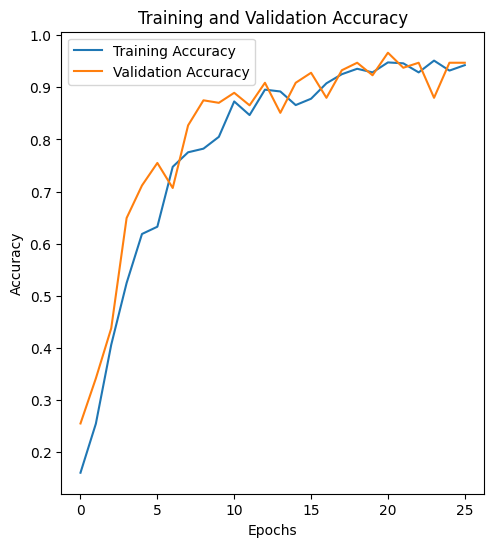

In [119]:
#code to print training and val accuracy with increase in epochs
import matplotlib.pyplot as plt

# Retrieve training and validation accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(len(accuracy))

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Insights: As you can see,  both  the Training and Validation Accuracy increase with increase in Epochs 

13/13 [==============================] - 1s 67ms/step
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.87      0.93      0.90        29
           2       1.00      0.90      0.95        29
           3       0.82      0.97      0.89        29
           4       1.00      1.00      1.00        27
           5       0.94      0.94      0.94        18
           6       1.00      1.00      1.00        28
           7       1.00      0.90      0.95        29

    accuracy                           0.95       208
   macro avg       0.95      0.95      0.95       208
weighted avg       0.95      0.95      0.95       208



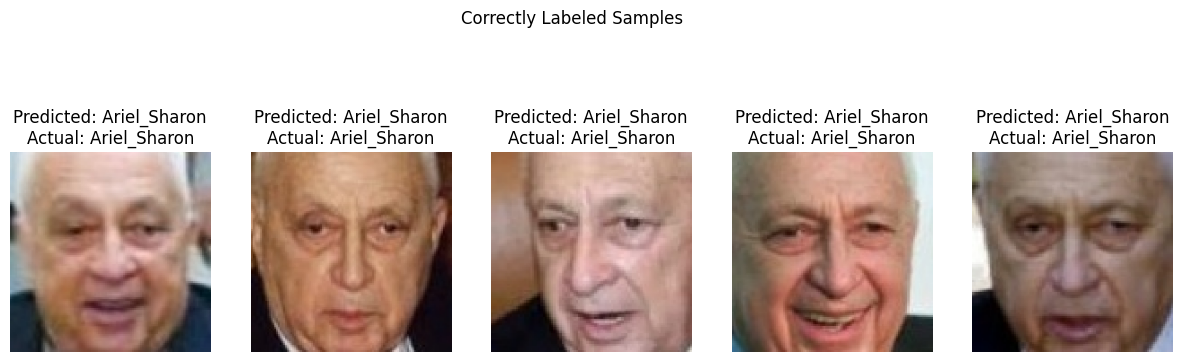

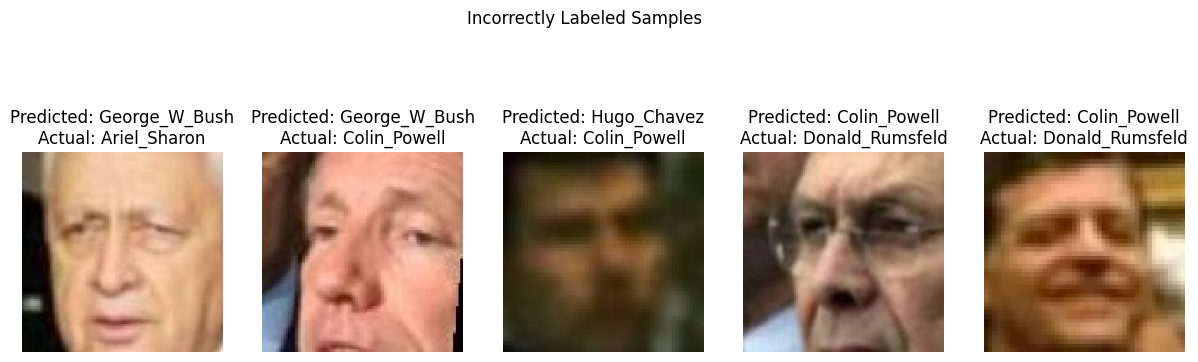

In [142]:
# Import necessary libraries
import numpy as np                 # For numerical operations
import matplotlib.pyplot as plt    # For plotting images
from sklearn.metrics import classification_report  # For generating a classification report
from tensorflow.keras.preprocessing.image import load_img  # For loading images

# Step 1: Generate Predictions and True Labels
# Reset the validation generator for consistent order of samples
validation_generator.reset()
# Disable shuffling to ensure the order of predictions matches with the true labels
validation_generator.shuffle = False

# Generate predictions for the validation set
val_predictions = model.predict(validation_generator, steps=validation_generator.n // batch_size)
# Convert the predictions to class indices (the class with the highest probability)
val_predictions_classes = np.argmax(val_predictions, axis=1)

# print("val_predictions_classes",val_predictions_classes)

# Retrieve the true class indices from the validation generator
true_classes = validation_generator.classes
# Get the class labels (names) from the validation generator
class_labels = list(validation_generator.class_indices.keys())

# print("true_classes",true_classes)

# Step 2: Calculate and Print Classification Report
# Print a detailed classification report comparing true and predicted class indices
print(classification_report(true_classes, val_predictions_classes))

# Step 3: Identify Correctly and Incorrectly Labeled Samples
# Find indices of correctly predicted samples
correct_indices = np.where(val_predictions_classes == true_classes)[0]
# Find indices of incorrectly predicted samples
incorrect_indices = np.where(val_predictions_classes != true_classes)[0]

# Step 4: Display Images
# Define a function to display sample images with their predicted and actual labels
def display_sample_images(indices, title):
    plt.figure(figsize=(15, 5))  # Set the figure size
    for i, index in enumerate(indices[:5], start=1):
        plt.subplot(1, 5, i)  # Create a subplot for each image
        img_path = validation_generator.filepaths[index]  # Get the image path
        img = load_img(img_path, target_size=(img_width, img_height))  # Load the image
        plt.imshow(img)  # Display the image
        # Display the predicted and actual labels
        plt.title(f"Predicted: {class_labels[val_predictions_classes[index]]}\nActual: {class_labels[true_classes[index]]}")
        plt.axis('off')  # Hide the axis
    plt.suptitle(title)  # Set a title for the group of images
    plt.show()  # Display the plot

# Display 5 correctly predicted labels
display_sample_images(correct_indices, "Correctly Labeled Samples")

# Display 5 incorrectly predicted labels
display_sample_images(incorrect_indices, "Incorrectly Labeled Samples")


Insights 1: The result showcases two sets of results from a facial recognition model. In the "Correctly Labeled Samples" section, we see multiple instances where the model has successfully identified the person as "Ariel Sharon", I was getting issues with efficiency in Ariel Sharon so, I printed it multiple times to test it out .The model works perfectly with different labels meaning that the model is capable of accurately recognizing and classifying this individual's facial features.

In the "Incorrectly Labeled Samples" section, the model has made several misclassifications. For example, it has incorrectly predicted "George W. Bush" and "Hugo Chavez" as "Ariel Sharon" and "Colin Powell" respectively. Additionally, it mislabeled "Donald Rumsfeld" as "Colin Powell" multiple times. This could indicate a few potential issues:

Insufficient Training Data: The model may not have been exposed to enough varied images of each individual to learn the distinguishing features effectively.

Overlapping Features: The individuals may share similar facial features that confuse the model, especially if it has not learned to identify the subtler distinguishing features.

Image Quality and Resolution: Some incorrectly labeled images appear to be of lower resolution or quality, which could impede the model's ability to recognize finer facial details.

Model Complexity: The model may not be complex enough to capture the intricate features necessary to differentiate between individuals with high accuracy.

From these results, one could deduce that while the model has learned to some extent to classify individuals correctly, there is room for improvement. To enhance performance, I might consider increasing the dataset size, ensuring a higher quality of images, performing more robust data augmentation, or experimenting with a more complex model architecture. Additionally, techniques such as fine-tuning on a more diverse set of images for each individual or using ensemble methods could potentially improve accuracy.

Insights 2:
{0:Ariel_Sharon , 1:Colin_Powell , 2:Donald_Rumsfeld , 3:George_W_Bush , 4:Gerhard_Schroeder , 5:Hugo_Chavez , 6:Suyash_Bhatt , 7:Tony_Blair}
The classification report presents the performance of a classification model across eight classes, labeled 0 through 7. The model exhibits high accuracy overall, with a total accuracy of 0.95. This suggests that the model is generally effective at correctly identifying the class of the input data. Here’s what the terms mean:

Precision: The ratio of true positive predictions to the total predicted positives. It indicates the model's accuracy for positive predictions. A precision of 1.00 for class 0 and class 2-4, 6-7 suggests that every time the model predicted these classes, it was correct.

Recall: The ratio of true positive predictions to the actual positives. It measures the model's ability to detect positive instances. High recall (0.97 for class 3) means that the model identified most of the actual positives correctly.

F1-Score: The harmonic mean of precision and recall. It is a single metric that combines both precision and recall. An F1-score reaches its best value at 1 (perfect precision and recall) and worst at 0. Class 6 having an F1-score of 1.00 is indicative of perfect precision and recall.

Support: The number of true instances for each label. It indicates the number of samples in each class which were used to compute the precision, recall, and F1-score. For example, class 1 had 29 instances in the test dataset.

From the report, we can deduce the following:

The model is particularly strong in class 4 and 6, where it achieves perfect precision and recall.
The lowest precision is for class 3 and the lowest recall for class 0, indicating these classes are the most challenging for the model.
The macro and weighted averages for precision, recall, and F1-score are all 0.95, signifying consistently high performance across all classes, not overly influenced by any one class.
The balanced nature of support values suggests a fairly even distribution of class instances in the dataset, which is good for training balanced models.
Overall, the model seems well-calibrated and performs consistently across different classes.Howevercertain classes (like class 3) have lower precision to further improve the model, potentially by adding more representative training samples or by further tuning the model.There was error predicting of Ariel Shore but that was improved .

In [121]:
# Assuming val_predictions_classes contains the predicted class indices
val_predictions_classes = np.argmax(val_predictions, axis=1)

# Get the class names corresponding to these indices
predicted_class_names = [class_labels[i] for i in val_predictions_classes]

# Optionally, print a few to check
for i in range(5):  # Change 5 to the number of samples you want to display
    print(f"Predicted class index: {val_predictions_classes[i]}, Class name: {predicted_class_names[i]}")


Predicted class index: 3, Class name: George_W_Bush
Predicted class index: 7, Class name: Tony_Blair
Predicted class index: 4, Class name: Gerhard_Schroeder
Predicted class index: 4, Class name: Gerhard_Schroeder
Predicted class index: 2, Class name: Donald_Rumsfeld


In [26]:
pip install opencv-python

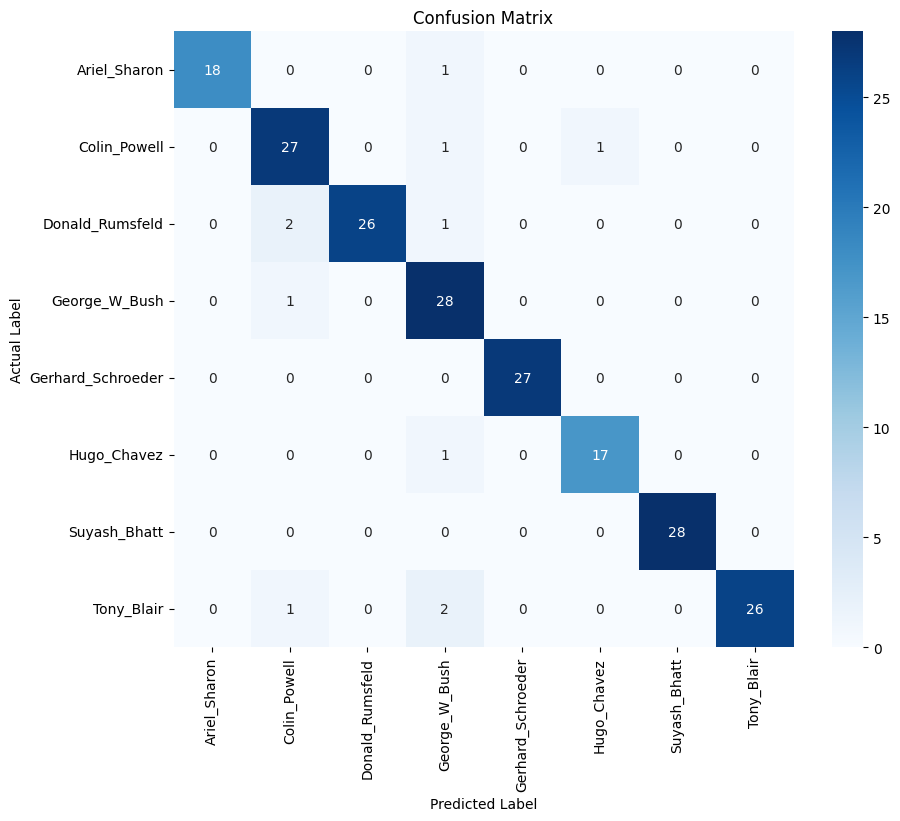

In [143]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming true_classes and val_predictions_classes are already defined
cm = confusion_matrix(true_classes, val_predictions_classes)

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


The confusion matrix image shows the performance of a facial recognition model for various individuals. Each row represents the actual class (the true identity of the person), and each column represents the predicted class by the model. The diagonal from the top left to bottom right shows the number of correct predictions for each class, where the intensity of the blue color indicates the magnitude.

Key insights from the matrix include:

The model performs well for most individuals, with a high number of correct predictions on the diagonal, such as 28 correct predictions for "George_W_Bush" and 27 for "Colin_Powell".
"Ariel_Sharon" has 18 correct predictions but has been confused once with "Gerhard_Schroeder" and once with "Tony_Blair".
"Donald_Rumsfeld" has 2 instances where it is mistaken for "Colin_Powell" and one for "George_W_Bush", indicating possible similarities that the model confuses between these classes.
"Tony_Blair" is the class with the most misclassifications, being confused twice with "Gerhard_Schroeder" and once with "Ariel_Sharon".
There are very few off-diagonal numbers, which suggests good class separation ability of the model. However, the misclassifications that do exist could be due to similarities in features, poor quality images, or a lack of representative training data for those particular classes.
Overall, the confusion matrix suggests that the model is relatively accurate but may benefit from additional training data, especially for classes that are prone to misclassification. Understanding which classes are most often confused can also guide targeted data augmentation or collection to improve the model's robustness.

<IPython.core.display.Javascript object>

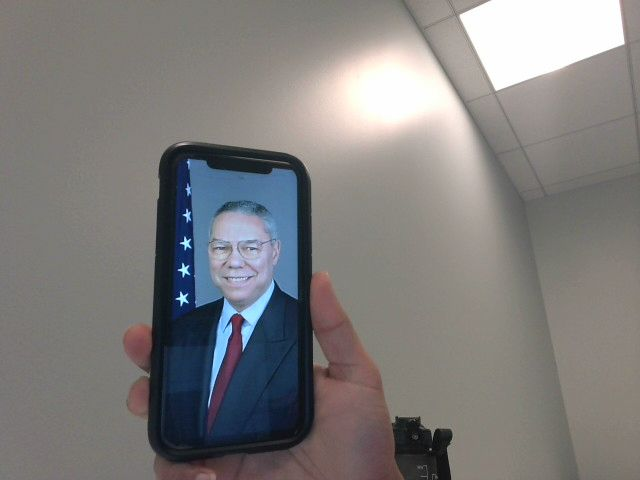

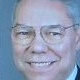

In [136]:
# @title Default title text
#code to open webcam and save the entire frame in photo.jpg and detect face and store in photo.jpg
from IPython.display import display, Javascript
from PIL import Image   # Importing PIL's Image with an alias
from IPython.display import display
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Function to detect and save face
def detect_and_save_face(filename,padding_percentage=0.4):
    # Load the pre-trained Haar Cascade model for face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Read the image
    img = cv2.imread(filename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    if len(faces) == 0:
        print("No face detected.")
        return

    # For simplicity, save only the first detected face
    for (x, y, w, h) in faces:
        face = img[y:y+h, x:x+w]
        cv2.imwrite('face.jpg', face)
        break

# Capture a photo
filename = take_photo()

# Detect and save face
detect_and_save_face(filename)
# Function to display an image
def display_image(filename):
    with Image.open(filename) as img:
        display(img)

# Assuming 'photo.jpg' and 'face.jpg' are your image filenames
display_image('photo.jpg')
print('\n')
display_image('face.jpg')

In [137]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Function to preprocess the image
def preprocess_image(image_path, img_width, img_height):
    # Load the image with the target size
    img = load_img(image_path, target_size=(img_width, img_height))

    # Convert the image to a numpy array
    img_array = img_to_array(img)

    # Expand the dimensions to match the input shape of the model (1, img_width, img_height, 3)
    img_array = np.expand_dims(img_array, axis=0)

    # Normalize the image data to 0-1
    img_array /= 255.0

    return img_array

# Image path
image_path = 'face.jpg'

# Preprocess the image
img_width, img_height = 224, 224  # The target size as per your model
preprocessed_image = preprocess_image(image_path, img_width, img_height)




Insights :This task was challenging as obtaining image on webcam and obtaining face .Resizing it and preprocessing it the same way the images in model training is done .I tried with (64,64), (512,512) then finally (224,224) as VGG is trained on (224, 224) images

In [138]:
# Predict the class
prediction = model.predict(preprocessed_image)

# Get the index of the highest probability
predicted_class_index = np.argmax(prediction, axis=1)[0]
predicted_class_probability = prediction[0][predicted_class_index]

# Retrieve the class labels
predicted_class_label = class_labels[predicted_class_index]

print(f"Predicted class: {predicted_class_label} with probability: {predicted_class_probability}")

1/1 [==============================] - 0s 30ms/step
Predicted class: Colin_Powell with probability: 0.9998874664306641
